### 结构化数据分析(EDA)清单

#### 1. 数据加载与重塑 (Data Loading & Reshaping)

1.  **加载 `train.csv`**。
2.  **检查 `info()` 和 `isnull().sum()`**：检查缺失值和数据类型。`Pre_GSHH_NDVI` 和 `Height_Ave_cm` 是 `float` 吗？`Sampling_Date` 是 `object`（字符串）吗？
3.  **关键步骤：数据透视 (Pivot)**
    * `train.csv` 目前是“长格式”（long format），每张图片有5行。
    * 对于分析（尤其是相关性分析），你需要将其转换为“宽格式”（wide format）：`pivot(index='sample_id', columns='target_name', values='target')`。
    * 这将创建一个DataFrame，其中**每行代表一张图片（一个`sample_id`）**，并有5个列：`Dry_Green_g`, `Dry_Dead_g`, `Dry_Clover_g`, `GDM_g`, `Dry_Total_g`。
    * 然后，将原始 `train.csv` 中的元数据（如 `State`, `Species`, `image_path` 等）合并 (merge) 回这个宽格式的DataFrame中。

#### 2. 目标变量分析 (Target Analysis) - *最重要*

这是为了理解你的5个预测目标。

1.  **分布**：为5个目标变量分别绘制直方图 (histograms) 或 KDE 图。
    * *问题*：它们是否高度偏斜（skewed）？（例如，大量接近0的值，少数非常高的值）。
    * *决策*：如果它们是右偏的（例如像对数正态分布），你可能需要在训练模型时对它们进行**对数变换**（`log(1 + x)`），并在预测后转回（`exp(x) - 1`）。这能让模型的损失函数（如MSE）更稳定。
2.  **相关性热图 (Correlation Heatmap)**：
    * 计算5个目标变量之间的皮尔逊相关系数 (Pearson correlation) 并绘制热图。
    * *问题*：它们彼此之间的相关性有多强？
3.  **验证“总和”关系**：
    * 这是一个**关键假设**：根据数据描述，`Dry_Total_g` 听起来像是其他几个部分的总和。
    * 在你的代码中验证：`sum_check = df['Dry_Green_g'] + df['Dry_Dead_g'] + df['Dry_Clover_g']`
    * 然后检查 `(sum_check - df['Dry_Total_g']).abs().max()` 是否接近于0。
    * *决策*：如果 `Dry_Total_g` 确实是总和，你的模型可能只需要预测4个值（`GDM_g` 和其他三个组成部分），然后通过计算得出第5个。这可以简化模型并可能提高总分。
4.  **`GDM_g` vs `Dry_Green_g`**：
    * `GDM_g` 是“绿色干物质”，`Dry_Green_g` 是“干燥的绿色植被（不包括三叶草）”。
    * 绘制它们之间的散点图。它们的关系是什么？`GDM_g` 是否总是大于 `Dry_Green_g`？

#### 3. 特征分析 (Feature Analysis)

这是为了理解你的“表格数据分支”需要做什么。

1.  **数值特征 (`Pre_GSHH_NDVI`, `Height_Ave_cm`)**
    * 绘制直方图（查看分布）。
    * 绘制散点图 (Scatter plots)：`Height_Ave_cm` vs `Dry_Total_g`，`Pre_GSHH_NDVI` vs `GDM_g`。
    * *问题*：是否存在明显的线性或非线性关系？这告诉你它们是否是强预测因子。
2.  **类别特征 (`State`, `Species`)**
    * 绘制条形图 (Bar plots) 查看每个类别的样本数量（`value_counts()`）。
    * *问题*：是否存在样本极不平衡的类别？
    * 绘制箱形图 (Box plots)：`boxplot(x='State', y='Dry_Total_g')`。
    * *问题*：不同州或不同物种的生物量分布是否有显著差异？（如果是，说明这是个好特征）。
3.  **时间特征 (`Sampling_Date`)**
    * **特征工程**：将 `Sampling_Date` 转换为 `Month`, `Year`, `DayOfYear`。
    * 绘制箱形图：`boxplot(x='Month', y='GDM_g')` 和 `boxplot(x='Month', y='Dry_Dead_g')`。
    * *问题*：这能清晰地揭示**季节性**吗？（例如，`GDM_g` 在春季（9-11月）最高，`Dry_Dead_g` 在夏季末（2-3月）最高）。这将证实我之前关于三角函数特征（`sin(month)`, `cos(month)`）的建议是正确的。

#### 4. 图像数据（快速理智检查）

1.  **加载并显示**：随机抽取5-10张训练图片。
2.  **并排显示**：在每张图片旁边，打印出它对应的（宽格式）元数据和5个目标值。
3.  *问题*：这符合直觉吗？一张看起来郁郁葱葱、绿色的照片，其 `GDM_g` 和 `Dry_Green_g` 值是否真的很高？一张看起来干燥、布满枯草的照片，`Dry_Dead_g` 值是否很高？

完成这套EDA后，你将对数据有非常深刻的理解，并能100%确定如何处理特征工程、目标变换以及如何验证你的模型。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
df_long = pd.read_csv('/kaggle/input/csiro-biomass/train.csv')
print(df_long.head())
print(df_long.info())

# NAN check
print(df_long.isnull().sum())

# Duplicate check
print(df_long.duplicated().sum())

# Unique check
print(df_long.nunique())

                    sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000  
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984  
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751  
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735  
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total

In [3]:
print("2: Long to Wide")

# 1. pivot
# 使用 'image_path' 作为索引 (index)
# 'target_name' 作为列 (columns)
# 'target' 作为值 (values)
df_wide_targets = df_long.pivot(index='image_path', columns='target_name', values='target')

# 2. 提取元数据
# 'sample_id' 在这个上下文是多余的，因为它包含了target_name
# 需要 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm'
metadata_cols = ['image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']

# 检查可用的元数据列
available_metadata_cols = [col for col in metadata_cols if col in df_long.columns]

# 删除重复项，使用 'image_path'
df_meta = df_long[available_metadata_cols].drop_duplicates(subset='image_path')

# 将 'image_path' 设置为索引以便合并
df_meta = df_meta.set_index('image_path')

# 4. 合并元数据和目标
df_wide = df_meta.join(df_wide_targets)

# 5. 检查结果
print(f"\n成功重塑数据。宽格式现在有 {df_wide.shape[0]} 行 (样本) 和 {df_wide.shape[1]} 列。")
print(df_wide.head())

# 检查宽格式的 info()，确认没有NaN
df_wide.info()

# 定义目标列
target_cols = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']

2: Long to Wide

成功重塑数据。宽格式现在有 357 行 (样本) 和 10 列。
                       Sampling_Date State            Species  Pre_GSHH_NDVI  \
image_path                                                                     
train/ID1011485656.jpg      2015/9/4   Tas    Ryegrass_Clover           0.62   
train/ID1012260530.jpg      2015/4/1   NSW            Lucerne           0.55   
train/ID1025234388.jpg      2015/9/1    WA  SubcloverDalkeith           0.38   
train/ID1028611175.jpg     2015/5/18   Tas           Ryegrass           0.66   
train/ID1035947949.jpg     2015/9/11   Tas           Ryegrass           0.54   

                        Height_Ave_cm  Dry_Clover_g  Dry_Dead_g  Dry_Green_g  \
image_path                                                                     
train/ID1011485656.jpg         4.6667        0.0000     31.9984      16.2751   
train/ID1012260530.jpg        16.0000        0.0000      0.0000       7.6000   
train/ID1025234388.jpg         1.0000        6.0500      0.0000      

       Dry_Green_g  Dry_Dead_g  Dry_Clover_g       GDM_g  Dry_Total_g
count   357.000000  357.000000    357.000000  357.000000   357.000000
mean     26.624722   12.044548      6.649692   33.274414    45.318097
std      25.401232   12.402007     12.117761   24.935822    27.984015
min       0.000000    0.000000      0.000000    1.040000     1.040000
25%       8.800000    3.200000      0.000000   16.026100    25.271500
50%      20.800000    7.980900      1.423500   27.108200    40.300000
75%      35.083400   17.637800      7.242900   43.675700    57.880000
max     157.983600   83.840700     71.786500  157.983600   185.700000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

(Green + Dead + Clover) 与 Total_Dry 之间的差异:
count    3.570000e+02
mean     8.784314e-04
std      1.634275e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.105427e-15
max      3.088000e-01
dtype: float64


Text(0, 0.5, 'Green Dry Matter (GDM)')

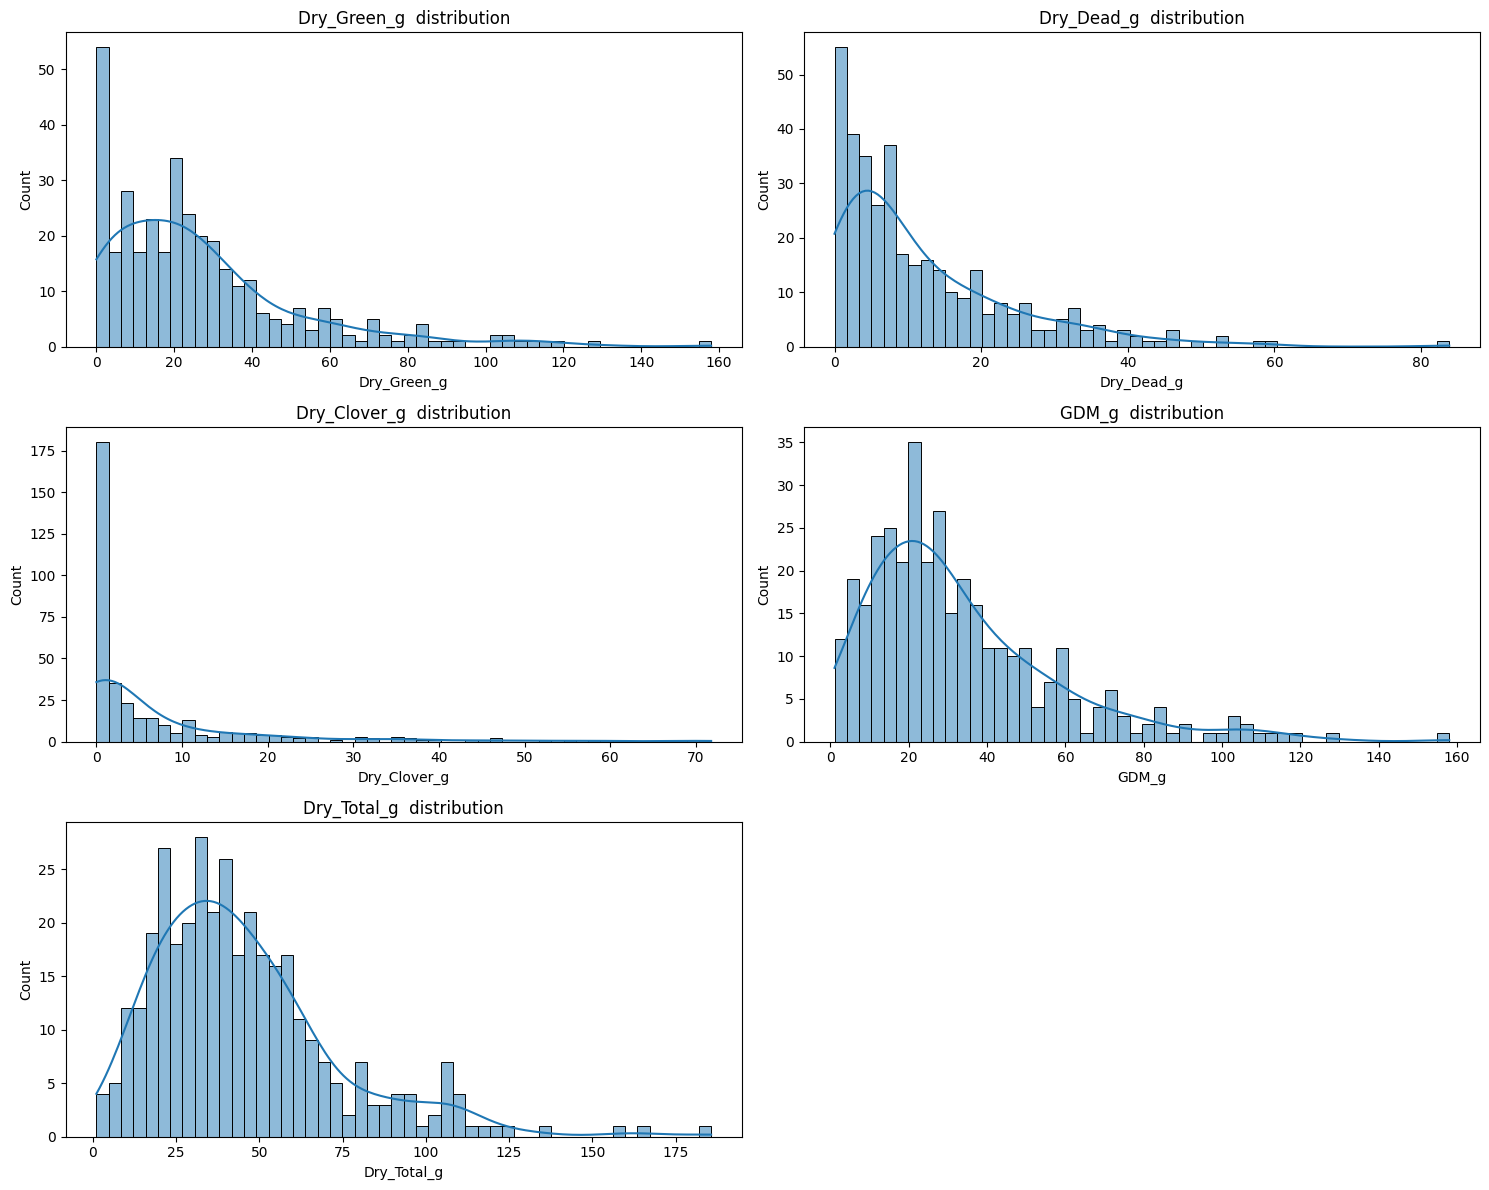

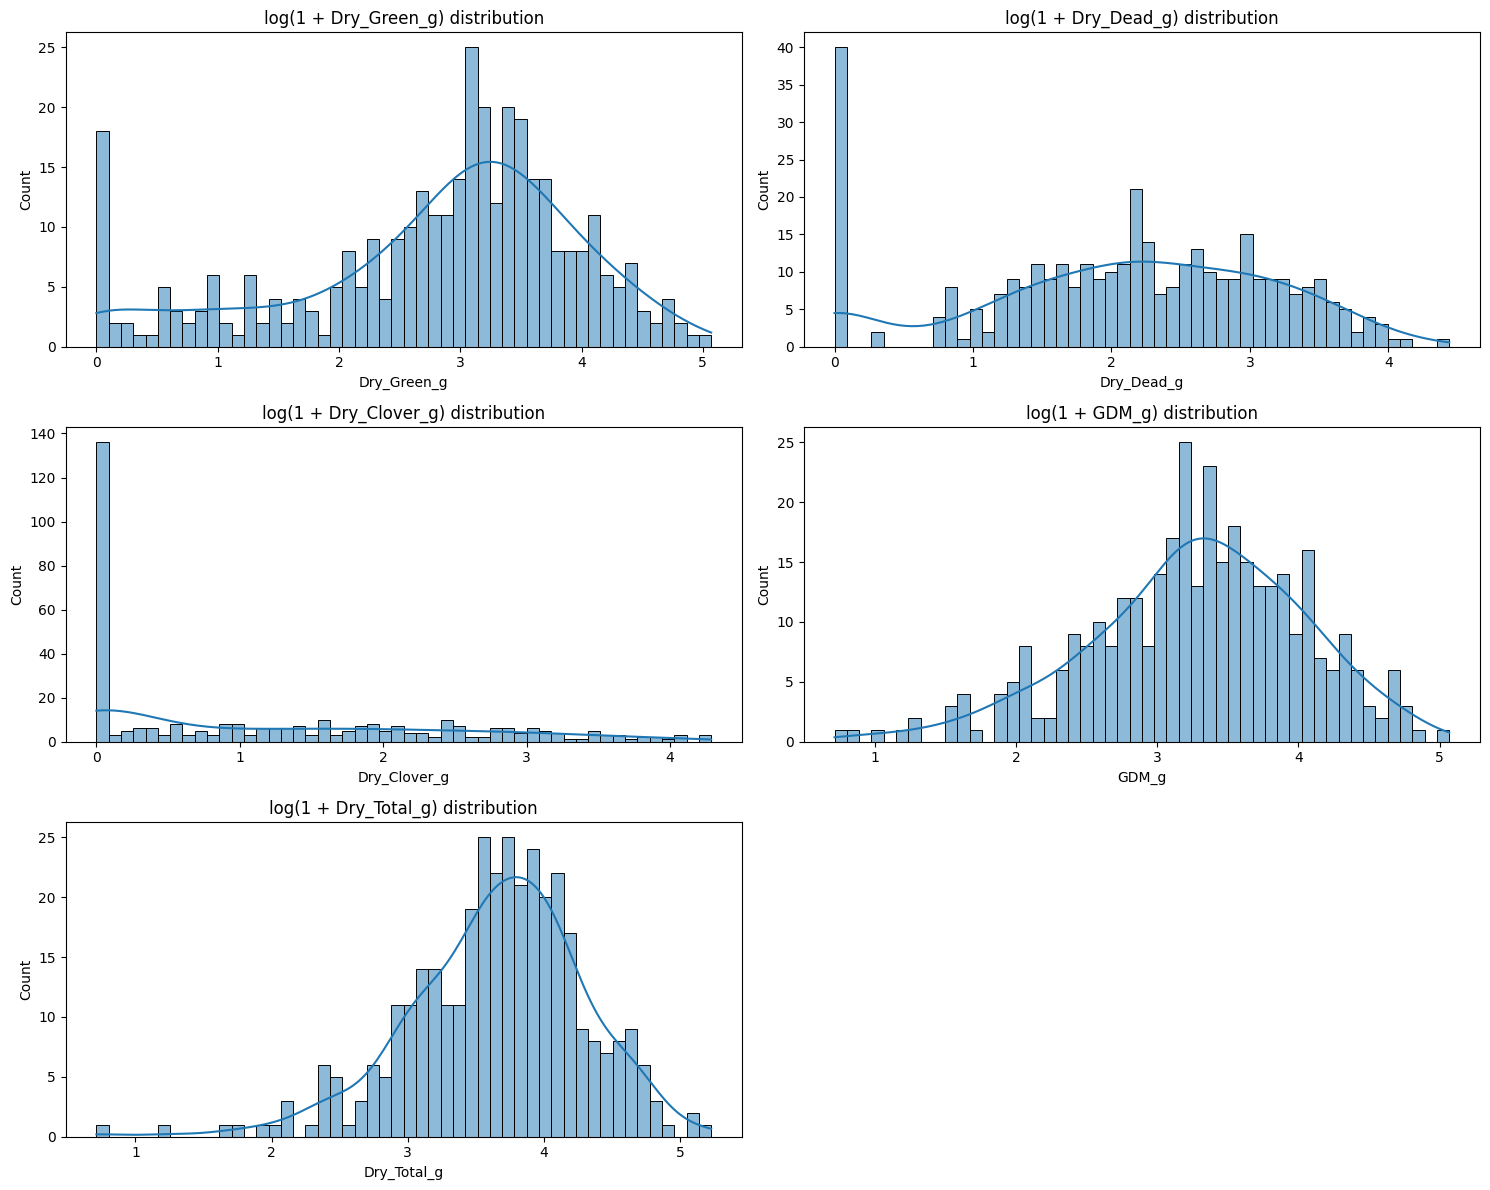

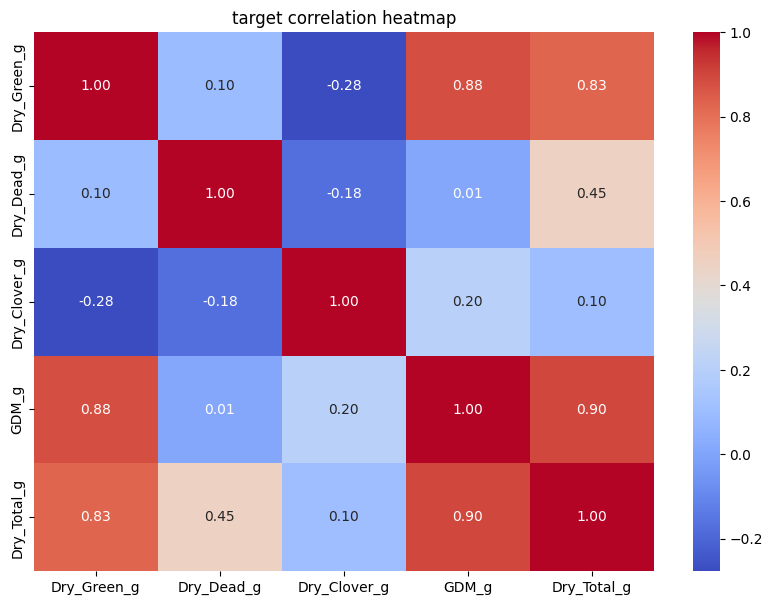

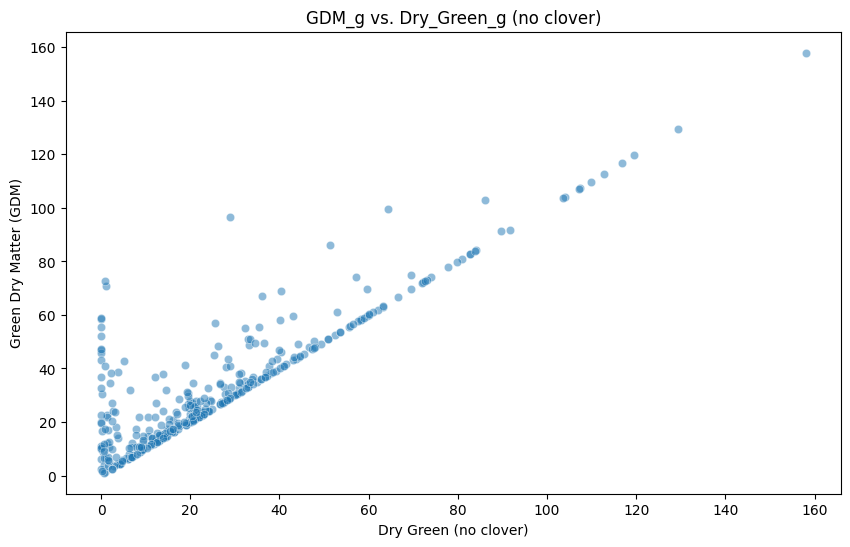

In [16]:
# --- 3. 目标变量分析 ---
print(df_wide[target_cols].describe())

# 绘制目标变量的直方图
plt.figure(figsize=(15, 12))
for i, col in enumerate(target_cols):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df_wide[col], kde=True, bins=50)
    plt.title(f'{col}  distribution')
plt.tight_layout()
    
plt.figure(figsize=(15, 12))
for i, col in enumerate(target_cols):
    plt.subplot(3, 2, i + 1)
     # 使用 log(1 + x) 来处理0值
    sns.histplot(np.log1p(df_wide[col]), kde=True, bins=50)
    plt.title(f'log(1 + {col}) distribution')
plt.tight_layout()


# 目标变量的相关性热图
plt.figure(figsize=(10, 7))
corr_matrix = df_wide[target_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('target correlation heatmap')

# 检查 Dry_Total_g 是否约等于 Green + Dead + Clover
sum_check = df_wide['Dry_Green_g'] + df_wide['Dry_Dead_g'] + df_wide['Dry_Clover_g']
difference = (sum_check - df_wide['Dry_Total_g']).abs()
print(f"(Green + Dead + Clover) 与 Total_Dry 之间的差异:")
print(difference.describe())
    
# 散点图: GDM_g vs Dry_Green_g
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_wide, x='Dry_Green_g', y='GDM_g', alpha=0.5)
plt.title('GDM_g vs. Dry_Green_g (no clover)')
plt.xlabel('Dry Green (no clover)')
plt.ylabel('Green Dry Matter (GDM)')

       Pre_GSHH_NDVI  Height_Ave_cm
count     357.000000     357.000000
mean        0.657423       7.595985
std         0.152142      10.285262
min         0.160000       1.000000
25%         0.560000       3.000000
50%         0.690000       4.000000
75%         0.770000       7.000000
max         0.910000      70.000000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


State
Tas    138
Vic    112
NSW     75
WA      32
Name: count, dtype: int64


Text(0.5, 1.0, 'seasonal trend: Dry_Dead_g (month)')

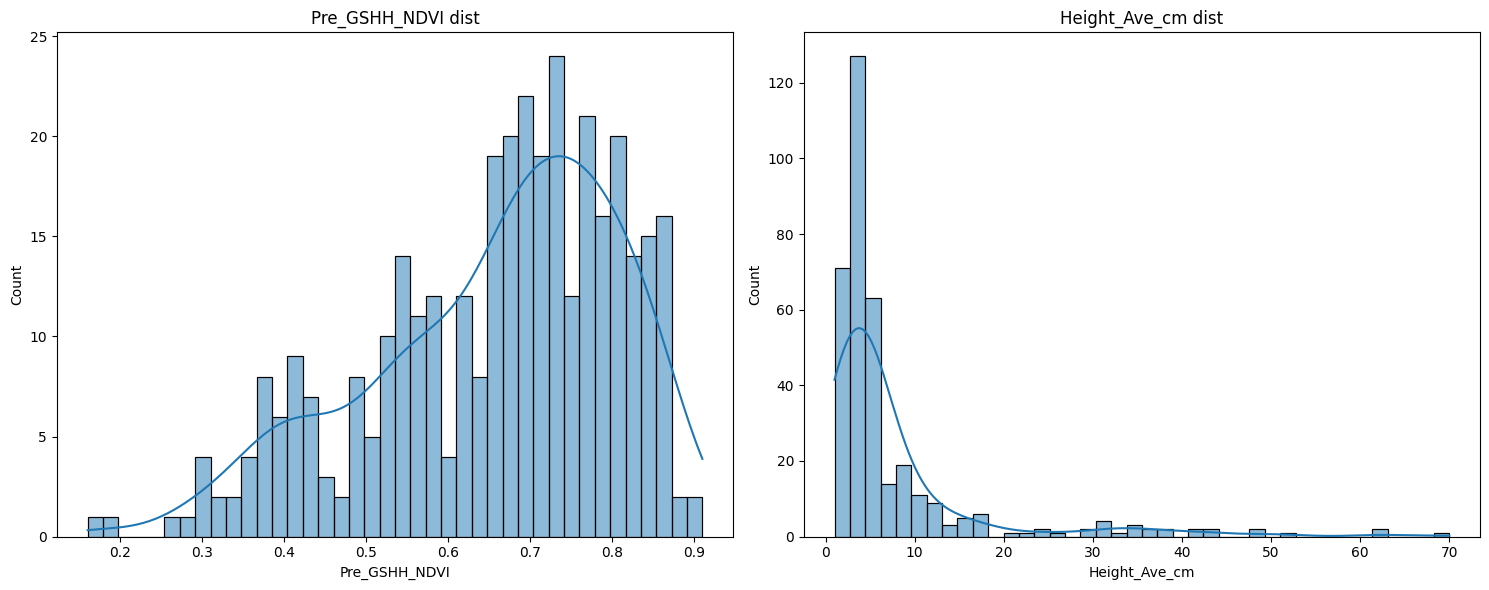

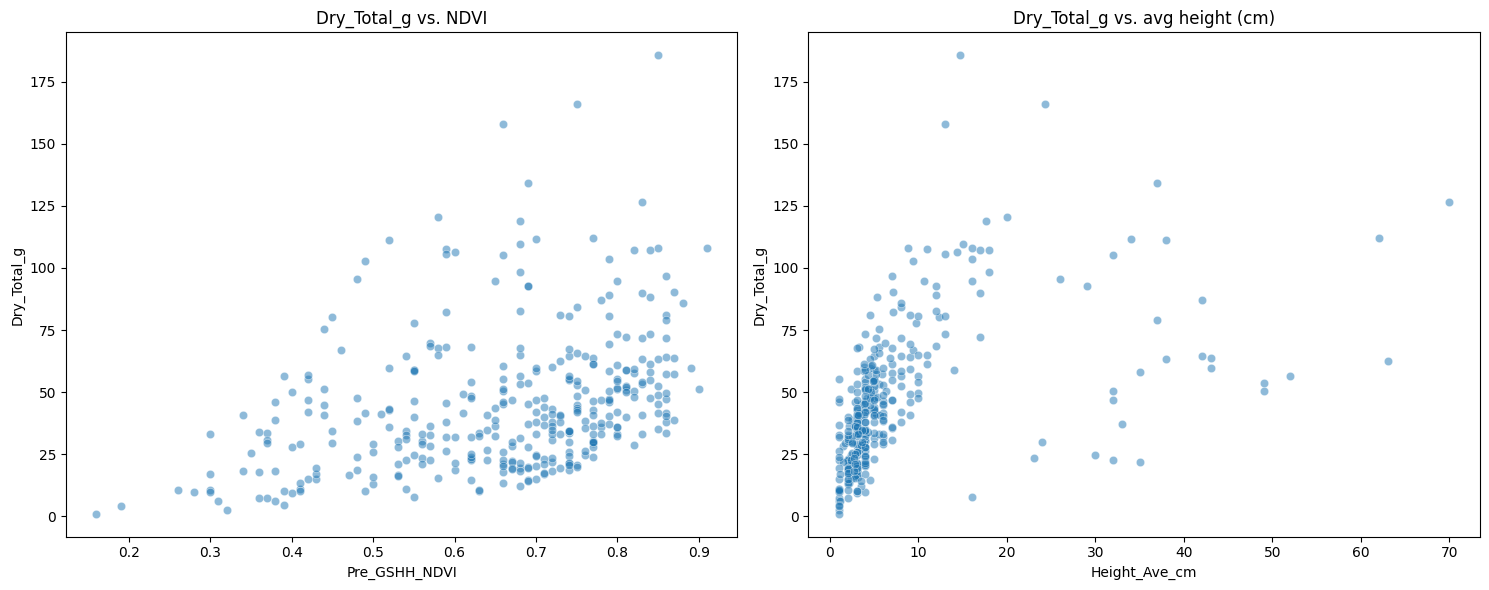

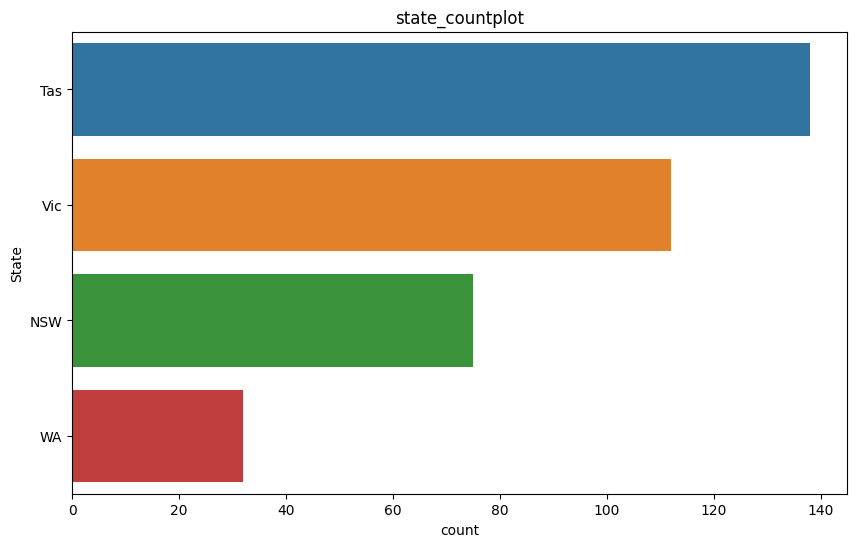

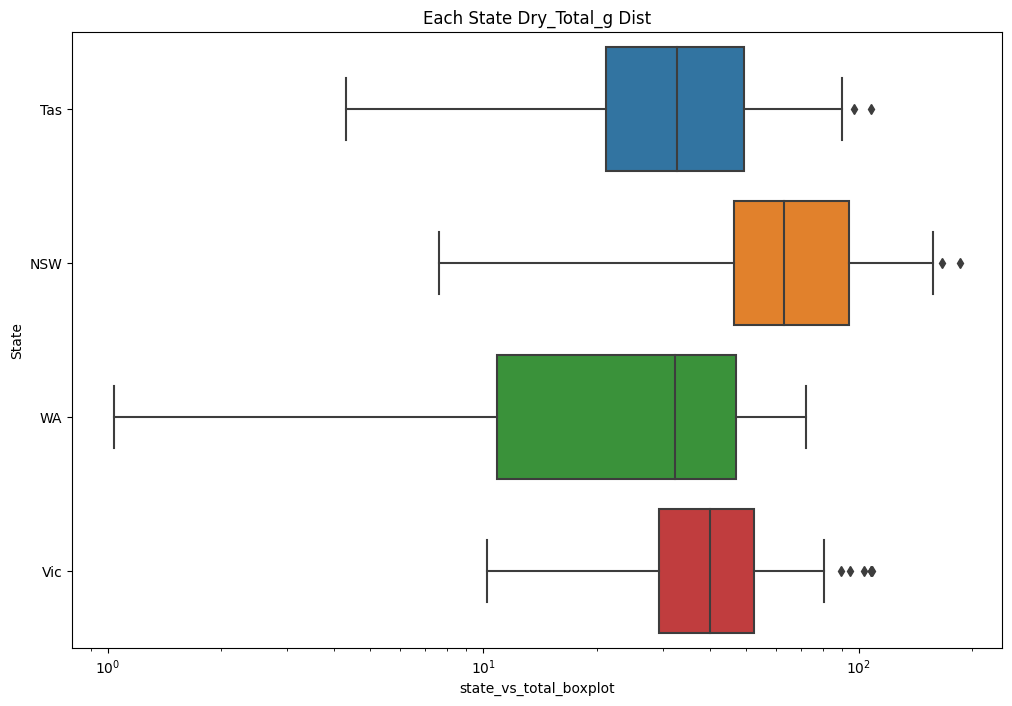

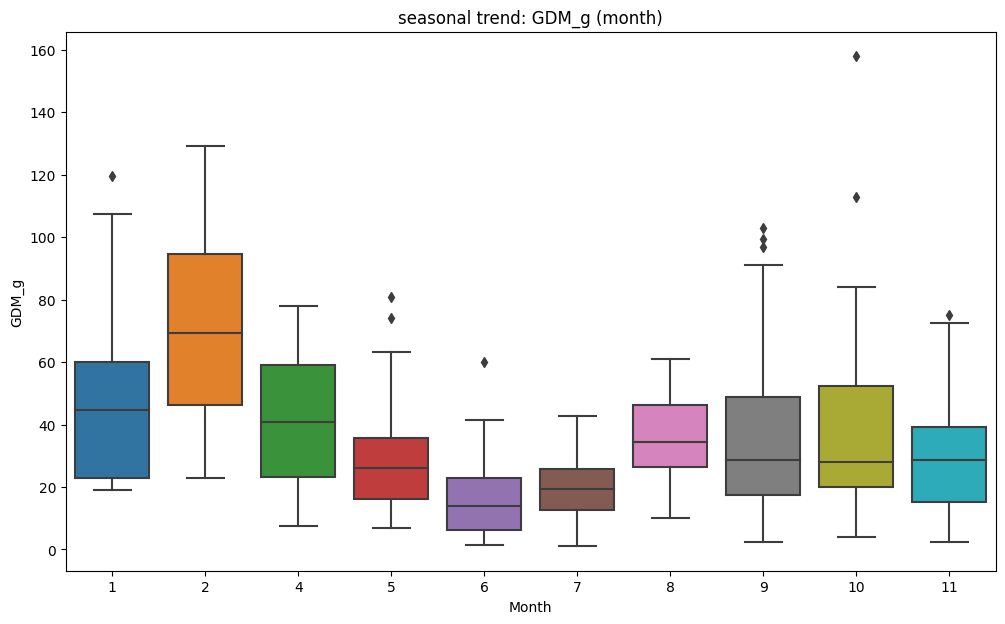

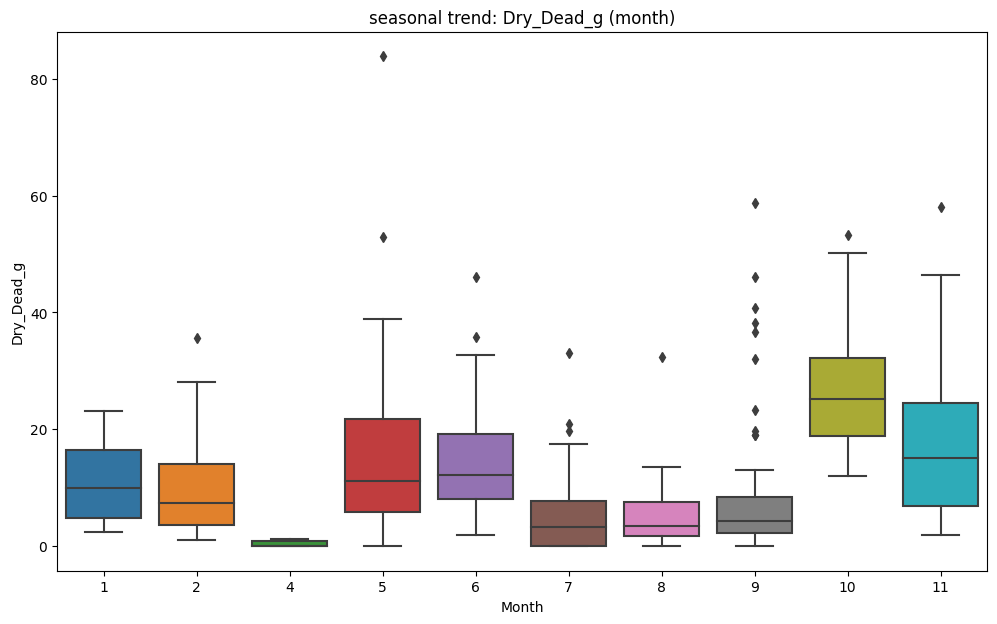

In [17]:
# --- 4. 特征分析 ---

# 数值特征
num_features = ['Pre_GSHH_NDVI', 'Height_Ave_cm']
print(df_wide[num_features].describe())

plt.figure(figsize=(15, 6))
for i, col in enumerate(num_features):
    plt.subplot(1, 2, i + 1)
    sns.histplot(df_wide[col], kde=True, bins=40)
    plt.title(f'{col} dist')
plt.tight_layout()

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_wide, x='Pre_GSHH_NDVI', y='Dry_Total_g', alpha=0.5)
plt.title('Dry_Total_g vs. NDVI')
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_wide, x='Height_Ave_cm', y='Dry_Total_g', alpha=0.5)
plt.title('Dry_Total_g vs. avg height (cm)')
plt.tight_layout()

# 类别特征: State
print(df_wide['State'].value_counts())
plt.figure(figsize=(10, 6))
sns.countplot(data=df_wide, y='State', order=df_wide['State'].value_counts().index)
plt.title('state_countplot')

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_wide, x='Dry_Total_g', y='State')
plt.title('Each State Dry_Total_g Dist')
plt.xscale('log') # 由于分布可能高度偏斜，使用对数尺度
plt.xlabel('state_vs_total_boxplot')

# 时间特征: Sampling_Date
df_wide['Sampling_Date'] = pd.to_datetime(df_wide['Sampling_Date'])
df_wide['Month'] = df_wide['Sampling_Date'].dt.month
df_wide['Year'] = df_wide['Sampling_Date'].dt.year
df_wide['DayOfYear'] = df_wide['Sampling_Date'].dt.dayofyear
    
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_wide, x='Month', y='GDM_g')
plt.title('seasonal trend: GDM_g (month)')
    
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_wide, x='Month', y='Dry_Dead_g')
plt.title('seasonal trend: Dry_Dead_g (month)')

  0%|          | 0/357 [00:00<?, ?it/s]


--- 图像尺寸分析 ---
宽度 (Widths) 统计:
width
2000    357
Name: count, dtype: int64

高度 (Heights) 统计:
height
1000    357
Name: count, dtype: int64
R 通道均值 (Mean): 0.4417, 标准差 (Std): 0.2364
G 通道均值 (Mean): 0.5036, 标准差 (Std): 0.2356
B 通道均值 (Mean): 0.3058, 标准差 (Std): 0.2220


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

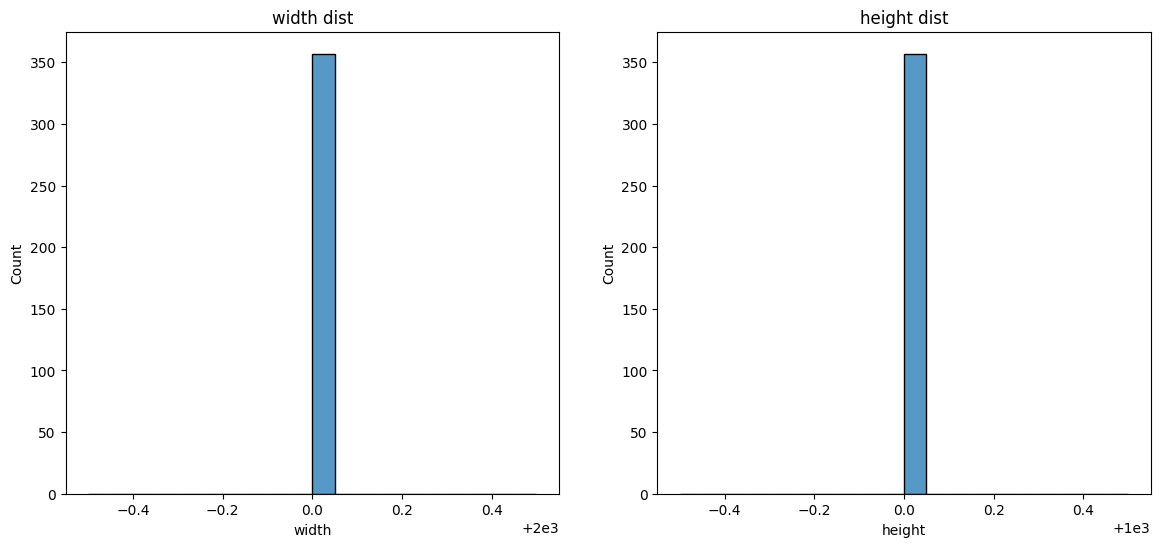

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

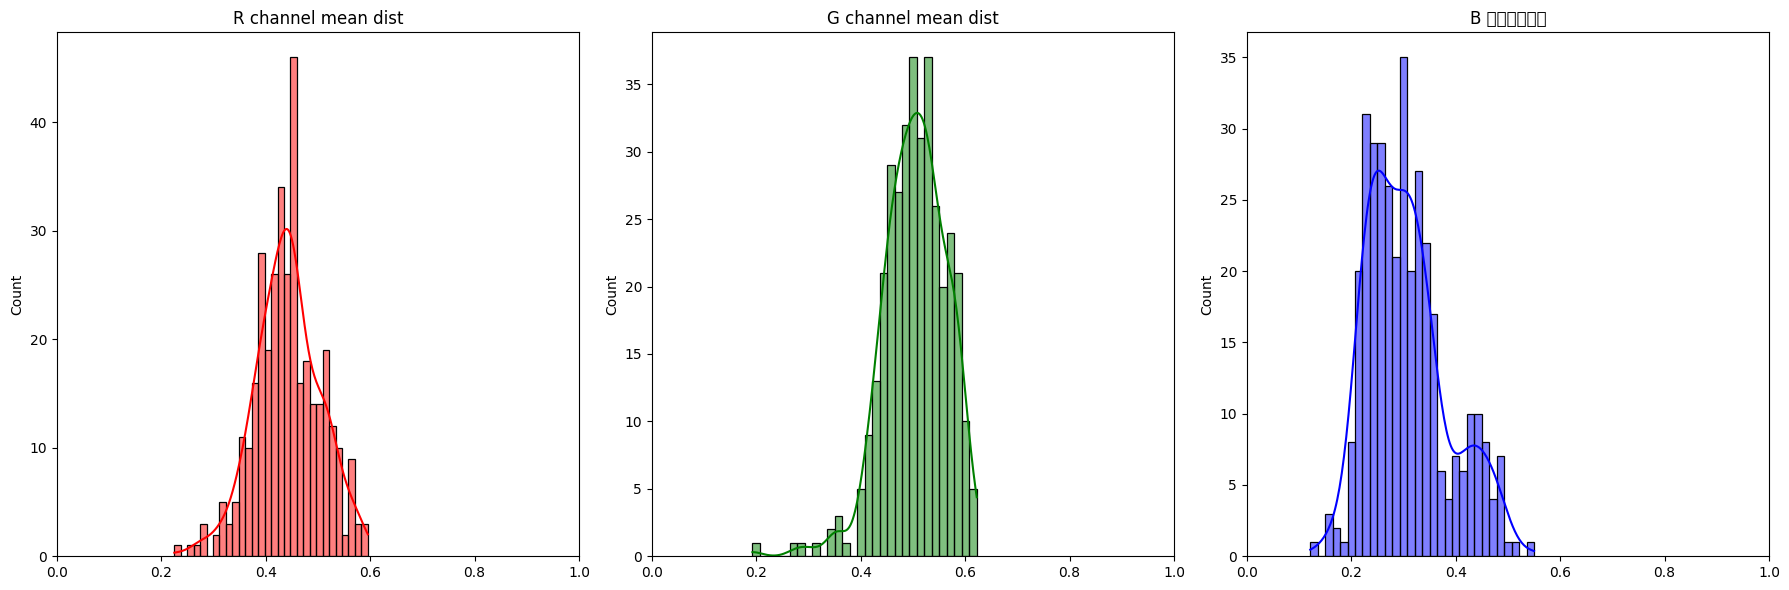

In [6]:
# --- 5. 图像数据快速检查 ---

# --- 1. 设置 ---
BASE_IMAGE_PATH = "/kaggle/input/csiro-biomass/"

# 存储统计数据的列表
widths = []
heights = []
r_means, g_means, b_means = [], [], []
r_stds, g_stds, b_stds = [], [], []

# --- 2. 遍历所有图像并收集数据 ---
for img_suffix in tqdm(df_wide.index):
    full_path = os.path.join(BASE_IMAGE_PATH, img_suffix)

    with Image.open(full_path) as img:
        # 1. 获取尺寸
        w, h = img.size
        widths.append(w)
        heights.append(h)
            
        # 2. 转换为 NumPy 数组以进行像素统计
        # 将其归一化到 [0, 1] 范围以便计算统计数据
        img_np = np.array(img) / 255.0 
            
        # 3. 计算每个通道 (R, G, B) 的均值和标准差
        # img_np 形状是 (height, width, 3)
        r_means.append(np.mean(img_np[:, :, 0]))
        g_means.append(np.mean(img_np[:, :, 1]))
        b_means.append(np.mean(img_np[:, :, 2]))
            
        r_stds.append(np.std(img_np[:, :, 0]))
        g_stds.append(np.std(img_np[:, :, 1]))
        b_stds.append(np.std(img_np[:, :, 2]))


# --- 3. 分析尺寸 ---
print("\n--- 图像尺寸分析 ---")
df_dims = pd.DataFrame({'width': widths, 'height': heights})

print("宽度 (Widths) 统计:")
print(df_dims['width'].value_counts())

print("\n高度 (Heights) 统计:")
print(df_dims['height'].value_counts())

# 绘制尺寸分布图
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_dims['width'], kde=False, bins=20)
plt.title('width dist')

plt.subplot(1, 2, 2)
sns.histplot(df_dims['height'], kde=False, bins=20)
plt.title('height dist')

# --- 4. 分析色彩分布 ---
# 打印所有通道的总体均值和标准差
print(f"R 通道均值 (Mean): {np.mean(r_means):.4f}, 标准差 (Std): {np.mean(r_stds):.4f}")
print(f"G 通道均值 (Mean): {np.mean(g_means):.4f}, 标准差 (Std): {np.mean(g_stds):.4f}")
print(f"B 通道均值 (Mean): {np.mean(b_means):.4f}, 标准差 (Std): {np.mean(b_stds):.4f}")

# 绘制每个通道均值的分布图
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.histplot(r_means, kde=True, color='red', bins=30)
plt.title('R channel mean dist')
plt.xlim(0, 1)

plt.subplot(1, 3, 2)
sns.histplot(g_means, kde=True, color='green', bins=30)
plt.title('G channel mean dist')
plt.xlim(0, 1)

plt.subplot(1, 3, 3)
sns.histplot(b_means, kde=True, color='blue', bins=30)
plt.title('B 通道均值分布')
plt.xlim(0, 1)

plt.tight_layout()